### Theory Question 4

Compare computed results to "what you expect" (I.E. Hand Calculations)

FFT annotated with important extracted values (i.e. signal and noise) for each step

Represent the power in each FFT bin, not fft coefficients, in units of dBm.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

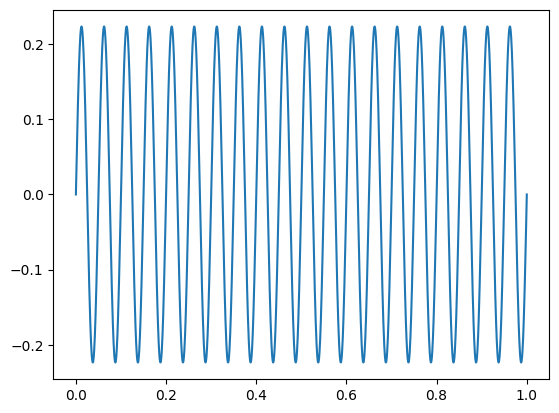

In [2]:
## make the initial plot
num_cycles = 20.0  # cycles
frequency  = 20e3  # Hz
power_dBm  = 0     # dBm
Z_l        = 50    # Ohms
f_sampling = 2e6   # Hz
noise_v    = 10e-3 # V

num_samples_period = int(f_sampling/frequency)
num_samples_total  = int(num_cycles * num_samples_period)

power_mW   = np.pow(10, power_dBm/10)    # mW
voltage = np.sqrt(power_mW * 1e-3 * Z_l)   # V

sample_times = np.linspace(0.0, 1.0, num_samples_total)

sample_phases = np.linspace(0.0, 2*np.pi*20, num_samples_total)
voltage_wave = voltage*np.sin(sample_phases)

plt.plot(sample_times, voltage_wave)

Text(0.5, 0, 'Time [s]')

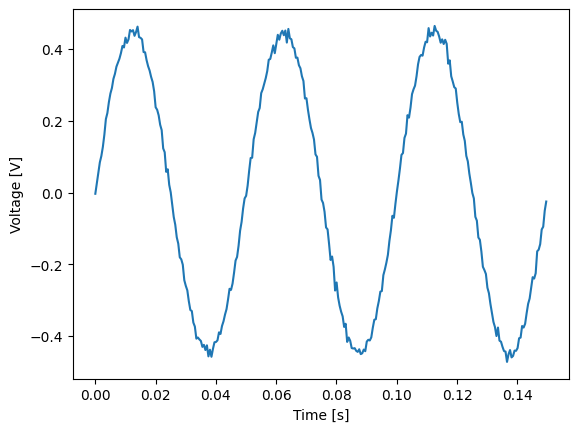

In [3]:
## add noise to the signal

real_wave = [ v + np.random.normal(loc=v, scale=noise_v) for v in voltage_wave]

plt.plot(sample_times[:300], real_wave[:300])
plt.ylabel("Voltage [V]")
plt.xlabel("Time [s]")

In [4]:
def create_real_wave(freq, fs, voltage, cycles, white_noise):
    num_samples_period = int(fs/freq)
    num_samples_total  = int(cycles * num_samples_period)
    sample_times = np.linspace(0.0, 1.0, num_samples_total)
    sample_phases = np.linspace(0.0, 2*np.pi*cycles, num_samples_total)
    voltage_wave = voltage*np.sin(sample_phases)
    real_wave = [ v + np.random.normal(loc=v, scale=white_noise) for v in voltage_wave]

    fig, axs = plt.subplots(1, 2, figsize=(50, 10))
    axs[0].plot(sample_phases, voltage_wave)
    axs[1].plot(sample_phases, real_wave)

    return real_wave

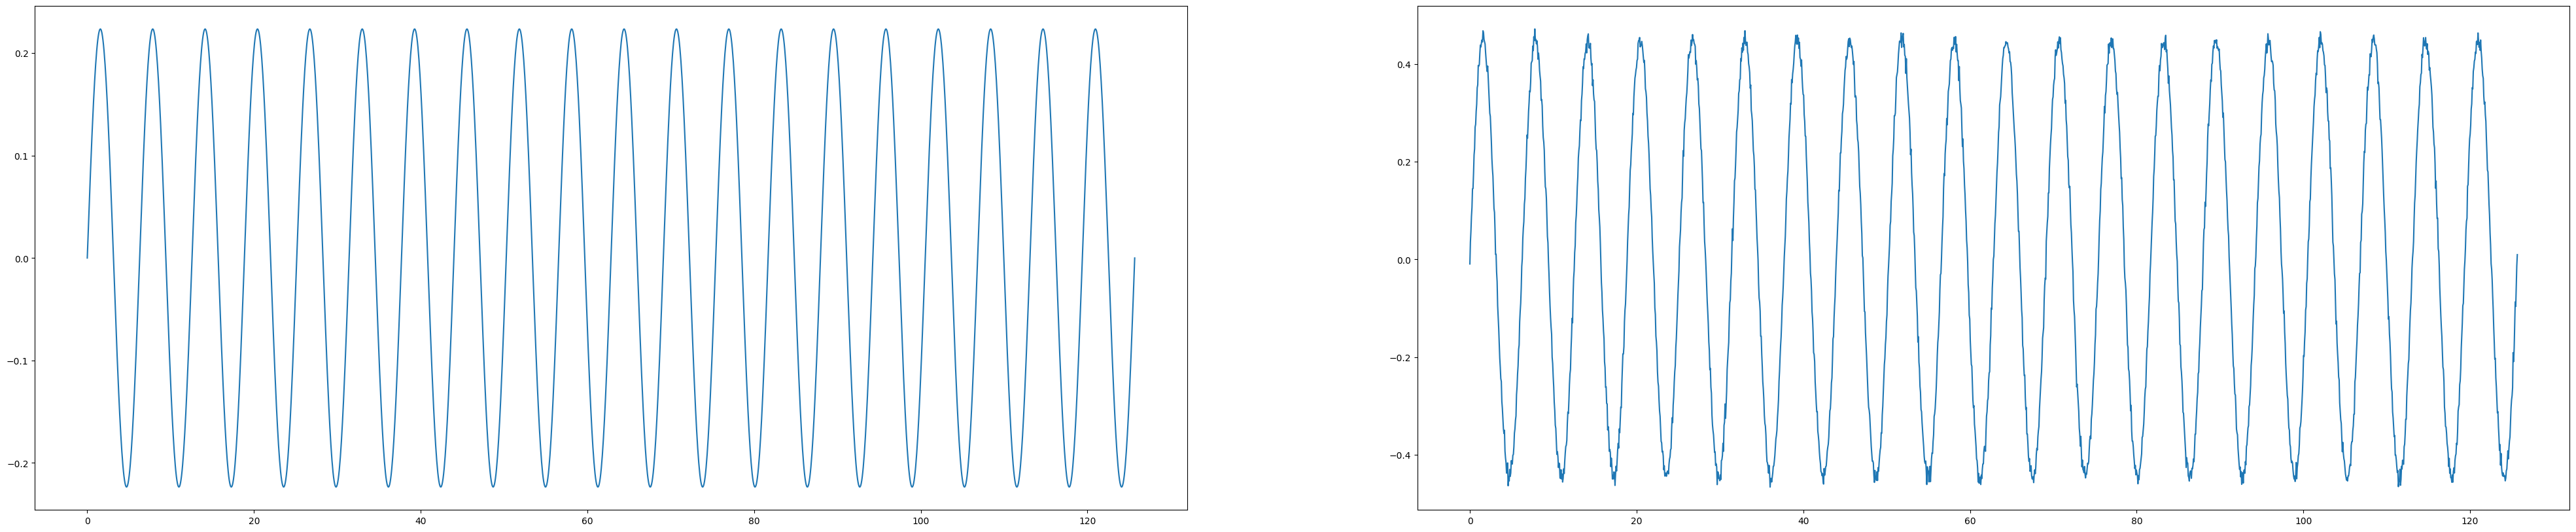

In [5]:
real_wave = create_real_wave(20e3, 2e6, voltage, 20, 10e-3)

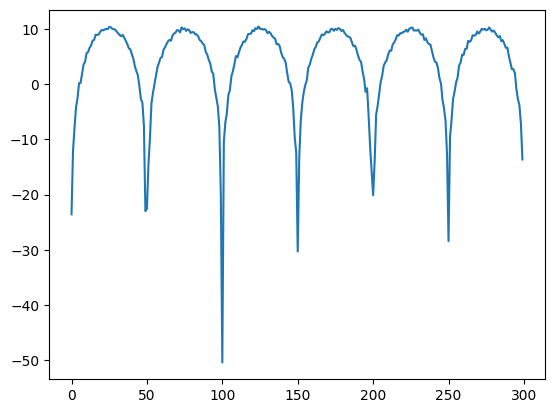

In [6]:
power_real_wave = [v**2 * Z_l for v in real_wave] # W
power_real_wave = 10 * np.log10(power_real_wave)  # dBm
plt.plot(power_real_wave[0:300])

Bin Width is 1000.0 Hz
There are 2000 bins
Recalculating Bin Width: 500.0


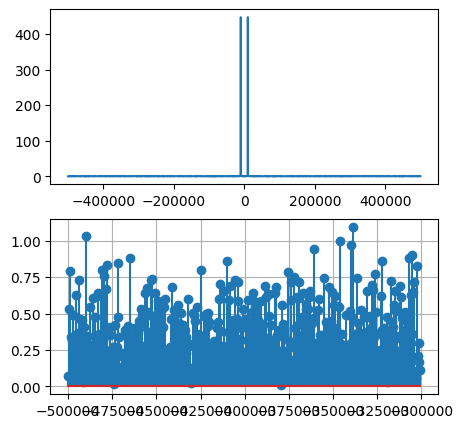

In [8]:
from scipy.fft import fft, ifft, fftshift
# used http://blog.dddac.com/noise-floor-and-s-n-ratio-in-and-with-fft-graphs/

## reassigning the number of points to the number of bins
num_bins = num_samples_total
freqPlot = fft(real_wave, num_bins)  # power is in dBm


bin_width = f_sampling / len(freqPlot)   # (np.max(np.abs(freqPlot)) - np.min(np.abs(freqPlot)))/num_bins
number_bins = len(freqPlot)
print(f"Bin Width is {bin_width} Hz")
print(f"There are {number_bins} bins")

sample_wavenum =   np.linspace(int(-len(freqPlot)/2), int(len(freqPlot)/2 - 1), len(freqPlot))
sample_freq    = [k*bin_width/2 for k in sample_wavenum]
# sample_freq    = [k*int(f_sampling/(2*len(freqPlot))) for k in sample_wavenum]

fig, axs2 = plt.subplots(2, 1, figsize=(5, 5))
axs2[0].plot(sample_freq, np.abs(fftshift(freqPlot)))
axs2[1].stem(sample_freq[0:400], np.abs(fftshift(freqPlot))[0:400])
axs2[1].grid()

print(f"Recalculating Bin Width: {f_sampling/(len(freqPlot)*2)}")

In [9]:
## Part B - Convert to 8-Bit ADC with max at 5A

def create_ADC_wave_pre_amp(freq, fs, voltage, cycles, white_noise, scaling):
    num_samples_period = int(fs/freq)
    num_samples_total  = int(cycles * num_samples_period)
    sample_times = np.linspace(0.0, 1.0, num_samples_total)
    sample_phases = np.linspace(0.0, 2*np.pi*cycles, num_samples_total)
    voltage_wave = voltage*np.sin(sample_phases)

    real_wave = []
    print(real_wave)
    for i in voltage_wave:
        if i < voltage * -3.0/4:
            # print(i, " lowest")
            real_wave.append(scaling*0)
        elif i < voltage * -2.0/4:
            # print(i, " sec lowest")
            real_wave.append(scaling*1.0/8)
        elif i < voltage * -1.0/4:
            # print(i, " third lowest")
            real_wave.append(scaling*2.0/8)
        elif i < voltage * 0:
            # print(i, " mid")
            real_wave.append(scaling*3.0/8)
        elif i < voltage * 1.0/4:
            # print(i, " third highest")
            real_wave.append(scaling*4.0/8)
        elif i < voltage * 2.0/4:
            # print(i, " sec highest")
            real_wave.append(scaling*5.0/8)
        elif i < voltage * 3.0/4:
            # print(i, " highest")
            real_wave.append(scaling*6.0/8)
        else:
            # print(i, " real high")
            real_wave.append(scaling*7.0/8)

    real_wave = [ (v + np.random.normal(loc=v, scale=white_noise)) for v in real_wave]

    fig, axs = plt.subplots(1, 2, figsize=(50, 10))
    axs[0].plot(sample_phases, voltage_wave)
    axs[1].plot(sample_phases, real_wave, '-o')

    return real_wave

## Part C - Convert to 8-Bit ADC with max at 5A

def create_ADC_wave_post_amp(freq, fs, voltage, cycles, white_noise, scaling):
    num_samples_period = int(fs/freq)
    num_samples_total  = int(cycles * num_samples_period)
    sample_times = np.linspace(0.0, 1.0, num_samples_total)
    sample_phases = np.linspace(0.0, 2*np.pi*cycles, num_samples_total)
    voltage_wave = scaling*voltage*np.sin(sample_phases)

    real_wave = []
    print(real_wave)
    for i in voltage_wave:
        if i < scaling*voltage * -3.0/4:
            # print(i, " lowest")
            real_wave.append(0)
        elif i < scaling*voltage * -2.0/4:
            # print(i, " sec lowest")
            real_wave.append(1.0/8)
        elif i < scaling*voltage * -1.0/4:
            # print(i, " third lowest")
            real_wave.append(2.0/8)
        elif i < scaling*voltage * 0:
            # print(i, " mid")
            real_wave.append(3.0/8)
        elif i < scaling*voltage * 1.0/4:
            # print(i, " third highest")
            real_wave.append(4.0/8)
        elif i < scaling*voltage * 2.0/4:
            # print(i, " sec highest")
            real_wave.append(5.0/8)
        elif i < scaling*voltage * 3.0/4:
            # print(i, " highest")
            real_wave.append(6.0/8)
        else:
            # print(i, " real high")
            real_wave.append(7.0/8)

    real_wave = [ (v + np.random.normal(loc=v, scale=white_noise)) for v in real_wave]

    fig, axs = plt.subplots(1, 2, figsize=(50, 10))
    axs[0].plot(sample_phases, voltage_wave)
    axs[1].plot(sample_phases, real_wave, '-o')

    return real_wave

[]
[]


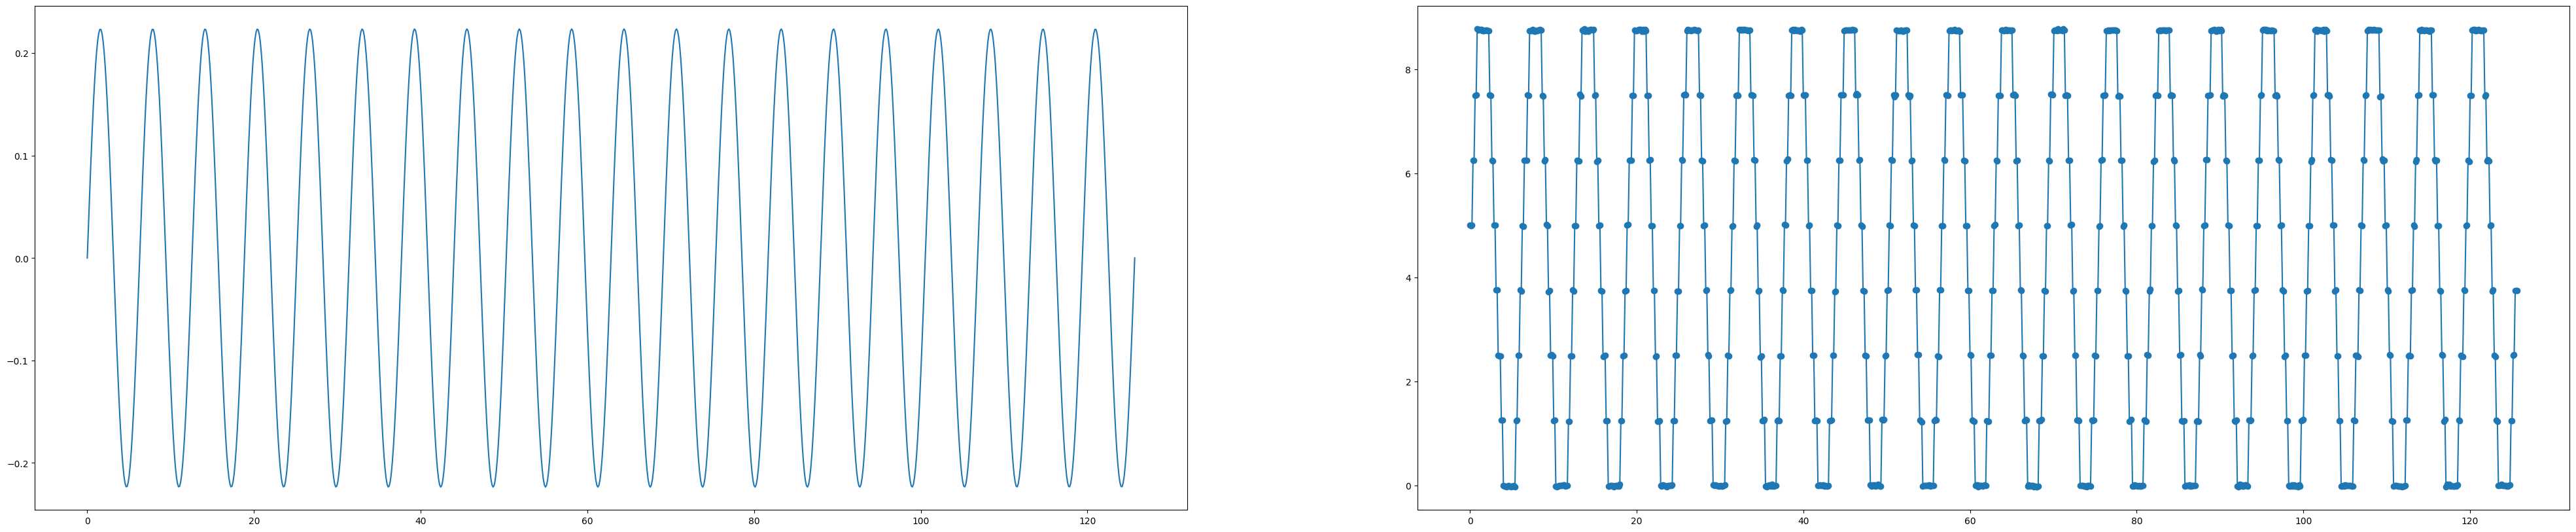

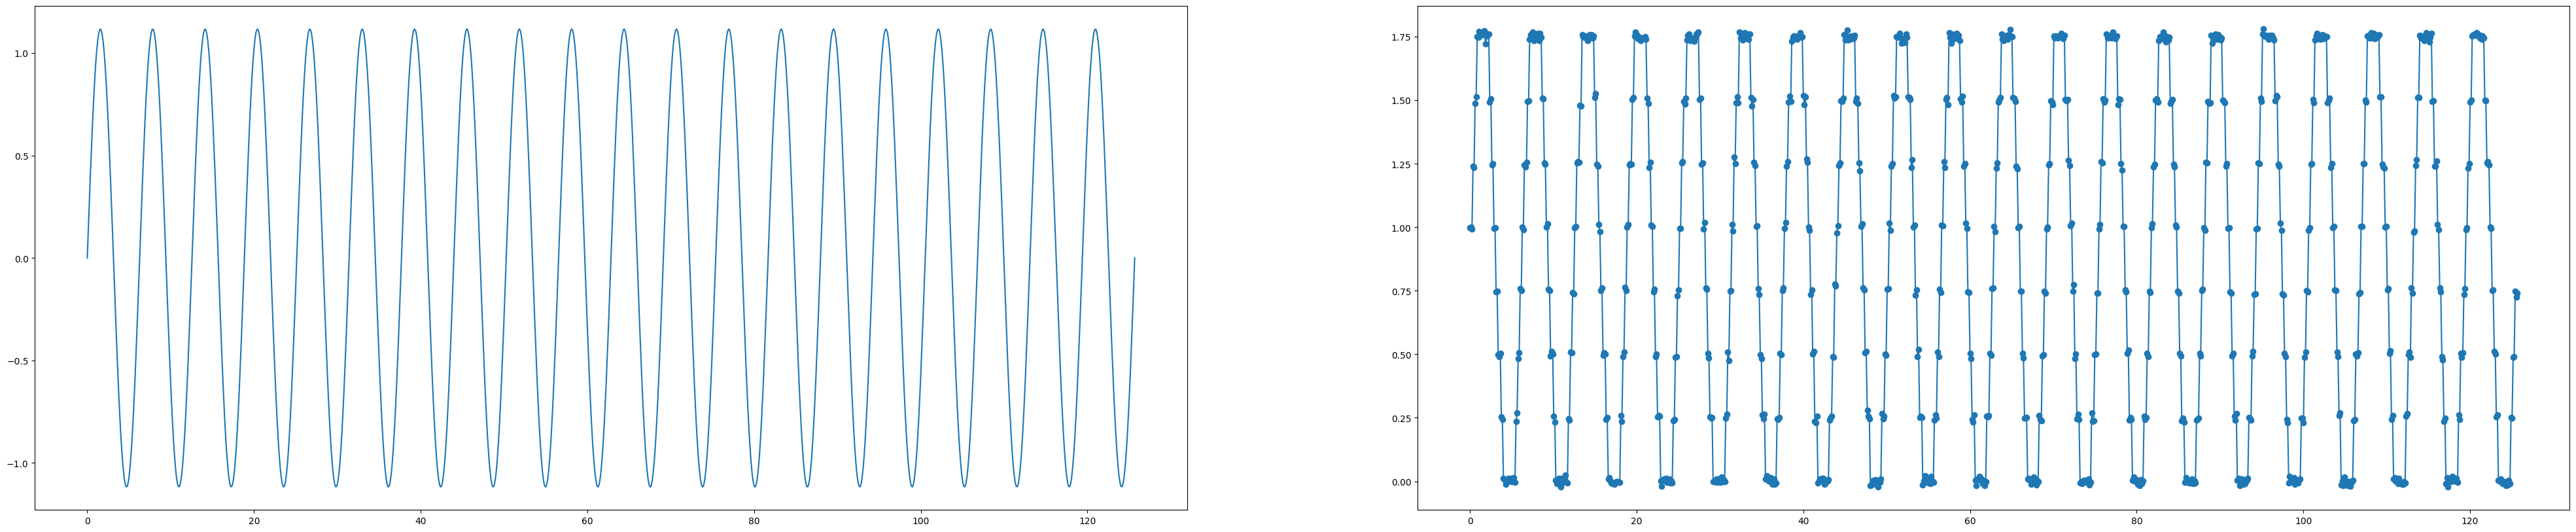

In [10]:
adc_wav_b = create_ADC_wave_pre_amp(20000, 1000000, voltage, 20, 10e-3, 5)
adc_wav_c = create_ADC_wave_post_amp(20000, 1000000, voltage, 20, 10e-3, 5)

Bin Width is 1000.0 Hz
There are 2000 bins
Bin Width is 1000.0 Hz
There are 2000 bins
Recalculating Bin Width: 500.0
Recalculating Bin Width: 500.0


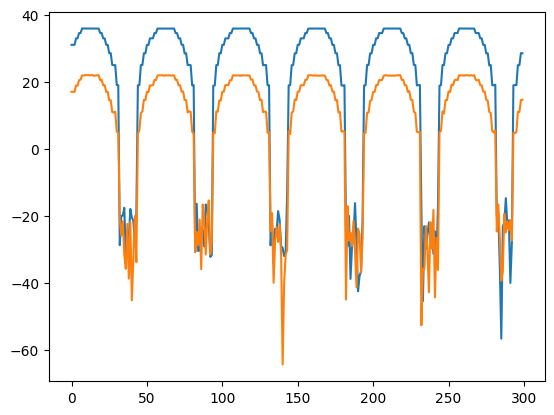

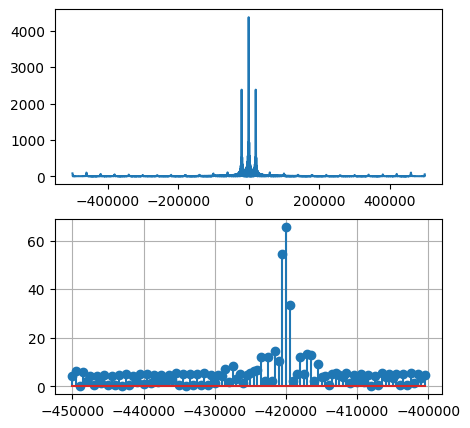

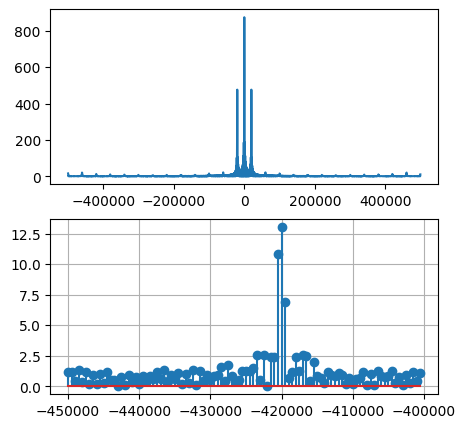

In [13]:
power_adc_wave_b = [v**2 * Z_l for v in adc_wav_b] # W
power_adc_wave_b = 10 * np.log10(power_adc_wave_b)  # dBm
plt.plot(power_adc_wave_b[0:300])

power_adc_wave_c = [v**2 * Z_l for v in adc_wav_c] # W
power_adc_wave_c = 10 * np.log10(power_adc_wave_c)  # dBm
plt.plot(power_adc_wave_c[0:300])



## reassigning the number of points to the number of bins
num_bins = num_samples_total
adc_fft_plot_b = fft(adc_wav_b, num_bins)  # power is in dBm

num_bins = num_samples_total
adc_fft_plot_c = fft(adc_wav_c, num_bins)  # power is in dBm

###

bin_width = f_sampling / len(adc_fft_plot_b)   # (np.max(np.abs(freqPlot)) - np.min(np.abs(freqPlot)))/num_bins
number_bins = len(adc_fft_plot_b)
print(f"Bin Width is {bin_width} Hz")
print(f"There are {number_bins} bins")

bin_width = f_sampling / len(adc_fft_plot_c)   # (np.max(np.abs(freqPlot)) - np.min(np.abs(freqPlot)))/num_bins
number_bins = len(adc_fft_plot_c)
print(f"Bin Width is {bin_width} Hz")
print(f"There are {number_bins} bins")



sample_wavenum_b =   np.linspace(int(-len(adc_fft_plot_b)/2), int(len(adc_fft_plot_b)/2 - 1), len(adc_fft_plot_b))
sample_freq    = [k*bin_width/2 for k in sample_wavenum]
# sample_freq    = [k*int(f_sampling/(2*len(freqPlot))) for k in sample_wavenum]

fig, axs2 = plt.subplots(2, 1, figsize=(5, 5))
axs2[0].plot(sample_freq, np.abs(fftshift(adc_fft_plot_b)))
axs2[1].stem(sample_freq[100:200], np.abs(fftshift(adc_fft_plot_b))[100:200])
axs2[1].grid()

print(f"Recalculating Bin Width: {f_sampling/(len(adc_fft_plot_b)*2)}")



sample_wavenum =   np.linspace(int(-len(adc_fft_plot_c)/2), int(len(adc_fft_plot_c)/2 - 1), len(adc_fft_plot_c))
sample_freq    = [k*bin_width/2 for k in sample_wavenum]
# sample_freq    = [k*int(f_sampling/(2*len(freqPlot))) for k in sample_wavenum]

fig, axs2 = plt.subplots(2, 1, figsize=(5, 5))
axs2[0].plot(sample_freq, np.abs(fftshift(adc_fft_plot_c)))
axs2[1].stem(sample_freq[100:200], np.abs(fftshift(adc_fft_plot_c))[100:200])
axs2[1].grid()

print(f"Recalculating Bin Width: {f_sampling/(len(adc_fft_plot_c)*2)}")

Text(0.5, 1.0, 'Zoom on FFT Plot with ADC post 5 V')

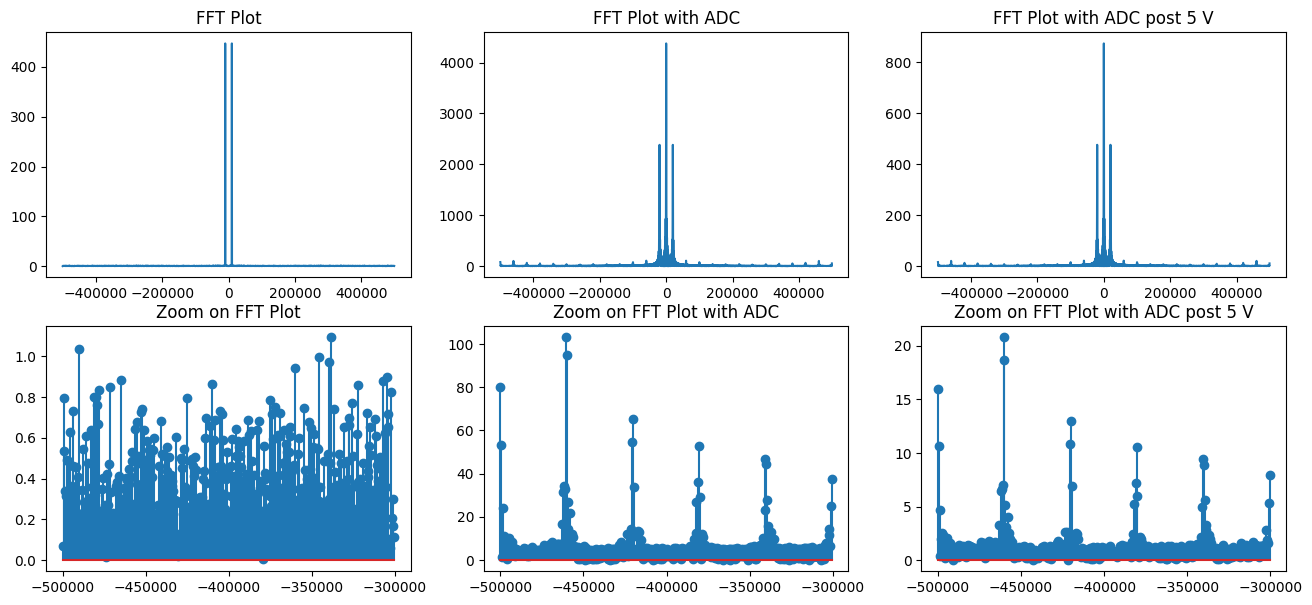

In [17]:
## Comparing Real Signal and ADC Signal (i.e. looking at impact of quantization)

fig, axs2 = plt.subplots(2, 3, figsize=(16, 7))
axs2[0][0].plot(sample_freq, np.abs(fftshift(freqPlot)))
axs2[0][0].set_title("FFT Plot")
# axs2[0][0].set_ylim([0,17500])

axs2[1][0].stem(sample_freq[0:400], np.abs(fftshift(freqPlot))[0:400])
axs2[1][0].set_title("Zoom on FFT Plot")
# axs2[1][0].set_ylim([0,800])

axs2[0][1].plot(sample_freq, np.abs(fftshift(adc_fft_plot_b)))
axs2[0][1].set_title("FFT Plot with ADC")
# axs2[0][1].set_ylim([0,17500])

axs2[1][1].stem(sample_freq[0:400], np.abs(fftshift(adc_fft_plot_b))[0:400])
axs2[1][1].set_title("Zoom on FFT Plot with ADC")


axs2[0][2].plot(sample_freq, np.abs(fftshift(adc_fft_plot_c)))
axs2[0][2].set_title("FFT Plot with ADC post 5 V")
# axs2[0][2].set_ylim([0,17500])

axs2[1][2].stem(sample_freq[0:400], np.abs(fftshift(adc_fft_plot_c))[0:400])
axs2[1][2].set_title("Zoom on FFT Plot with ADC post 5 V")


# axs2.grid()

#### Plot Time Vs RBW/VBW

Text(0, 0.5, 'Sweep Time (s)')

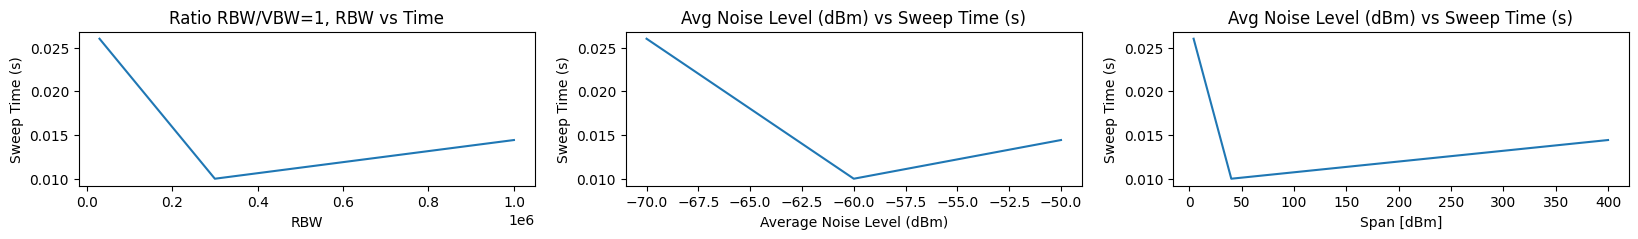

In [18]:
center_freq = 2.4e9       # Hz
rbw = [1e6, 300e3, 30e3]  # rate bandwidth
vbw = [1e6, 300e3, 30e3]  # video bandwidth
sweep_time = [14.43e-3, 10e-3, 26.03e-3] # seconds
span = [400, 40, 4]
avg_noise_lvl = [-50, -60, -70]

fig, axs = plt.subplots(1, 3, figsize=(20, 2))
axs[0].plot(rbw, sweep_time)
axs[0].set_title("Ratio RBW/VBW=1, RBW vs Time")
axs[0].set_xlabel("RBW")
axs[0].set_ylabel("Sweep Time (s)")

axs[1].plot(avg_noise_lvl, sweep_time)
axs[1].set_title("Avg Noise Level (dBm) vs Sweep Time (s)")
axs[1].set_xlabel("Average Noise Level (dBm)")
axs[1].set_ylabel("Sweep Time (s)")

axs[2].plot(span, sweep_time)
axs[2].set_title("Avg Noise Level (dBm) vs Sweep Time (s)")
axs[2].set_xlabel("Span [dBm]")
axs[2].set_ylabel("Sweep Time (s)")

Text(0, 0.5, 'Sweep Time (s)')

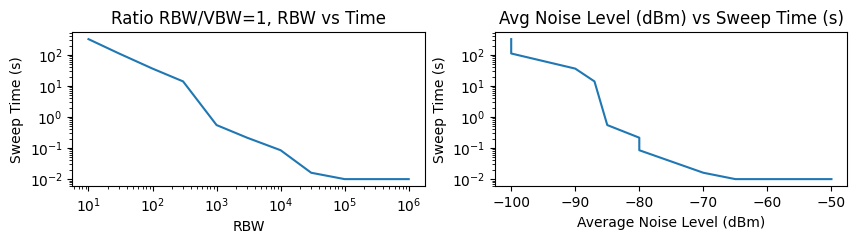

In [19]:
rbw =        [10,    30,      100,   300,   1e3, 3e3,   10e3,  30e3, 100e3, 300e3, 1e6]
sweep_time = [321600, 110900, 36130, 14000, 550, 215.4, 85.12, 16.03,   10,    10,  10]
sweep_time = [i*1e-3 for i in sweep_time]
avg_noise =  [-100, -100,     -90,   -87,  -85, -80,    -80,   -70,    -65,   -60, -50]

fig, axs = plt.subplots(1, 2, figsize=(10, 2))
axs[0].plot(rbw, sweep_time)
axs[0].set_title("Ratio RBW/VBW=1, RBW vs Time")
axs[0].set_xlabel("RBW")
axs[0].set_xscale("log")
axs[0].set_ylabel("Sweep Time (s)")
axs[0].set_yscale("log")

# fitted = np.polyfit(rbw, sweeptime

axs[1].plot(avg_noise, sweep_time)
axs[1].set_title("Avg Noise Level (dBm) vs Sweep Time (s)")
axs[1].set_xlabel("Average Noise Level (dBm)")
axs[1].set_yscale("log")
axs[1].set_ylabel("Sweep Time (s)")

-0.9191863612715845
7.547308909146294


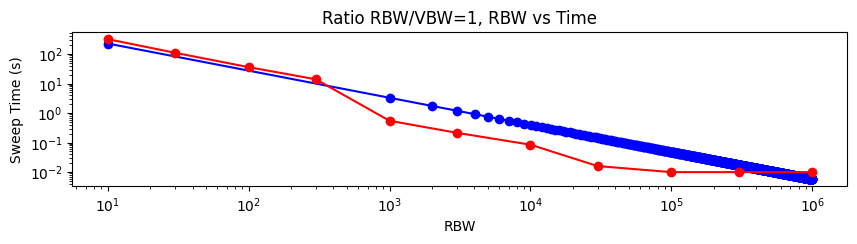

In [20]:

fig, axs = plt.subplots(1, 1, figsize=(10, 2))
slp_1b, int_1b = np.polyfit(np.log(sweep_time), np.log(rbw), 1)
points = np.linspace(10, 1000000, 1000)
gg = [np.exp(int_1b + slp_1b*np.log(i)) for i in points]

# print(gg)
axs.plot(points, gg, 'bo-')
axs.plot(rbw, sweep_time, 'ro-')
axs.set_title("Ratio RBW/VBW=1, RBW vs Time")
axs.set_xlabel("RBW")
axs.set_xscale("log")
axs.set_ylabel("Sweep Time (s)")
axs.set_yscale("log")

print(slp_1b)
print(int_1b)

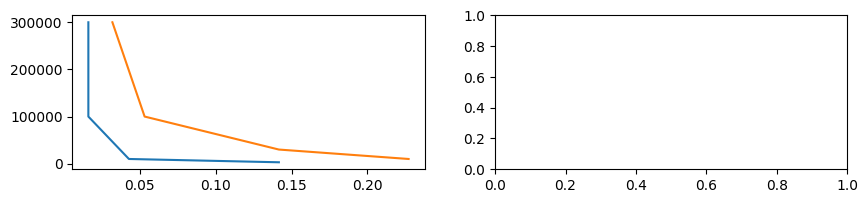

In [21]:
#ratio rbw to vbw
vbw_r30k = [3e3, 10e3, 100e3, 300e3]
sweep_time_r30k = [141.6e-3, 42.76e-3, 16.03e-3, 16.03e-3]

rbw_v3k = [10e3, 30e3, 100e3, 300e3]
sweep_time_v3k = [227.1e-3, 141.6e-3, 53.11e-3, 31.87e-3]

fig, axs = plt.subplots(1, 2, figsize=(10, 2))
axs[0].plot(sweep_time_r30k, vbw_r30k)
axs[0].plot(sweep_time_v3k, rbw_v3k)

[0.1, 0.3333333333333333, 3.3333333333333335, 10.0]
[0.3, 0.1, 0.03, 0.01]


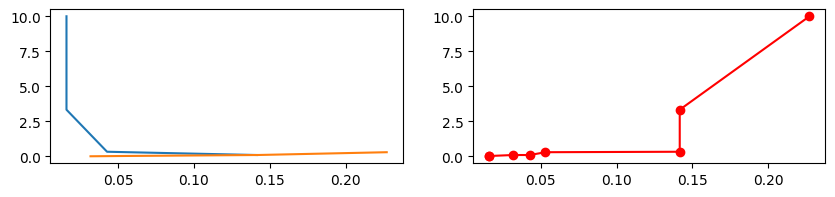

In [22]:
#ratio rbw to vbw
vbw_r30k = [3e3, 10e3, 100e3, 300e3]
sweep_time_r30k = [141.6e-3, 42.76e-3, 16.03e-3, 16.03e-3]

vbw_r30k_vtr = [i/30e3 for i in vbw_r30k]

rbw_v3k = [10e3, 30e3, 100e3, 300e3]
sweep_time_v3k = [227.1e-3, 141.6e-3, 53.11e-3, 31.87e-3]

rbw_v3k_vtr = [3e3/i for i in rbw_v3k]

print(vbw_r30k_vtr)
print(rbw_v3k_vtr)

fig, axs = plt.subplots(1, 2, figsize=(10, 2))
axs[0].plot(sweep_time_r30k, vbw_r30k_vtr)
axs[0].plot(sweep_time_v3k, rbw_v3k_vtr)

combined = np.concatenate((vbw_r30k_vtr, rbw_v3k_vtr), axis=0)
sorted_indices = np.argsort(combined)
combined_sorted = combined[sorted_indices]

combined_time = np.concatenate((sweep_time_r30k, sweep_time_v3k), axis=0)
sorted_indices_time = np.argsort(combined_time)
combined_time_sorted = combined_time[sorted_indices_time]

# print(sorted_indices_time)

axs[1].plot(combined_time_sorted, combined_sorted, 'ro-')

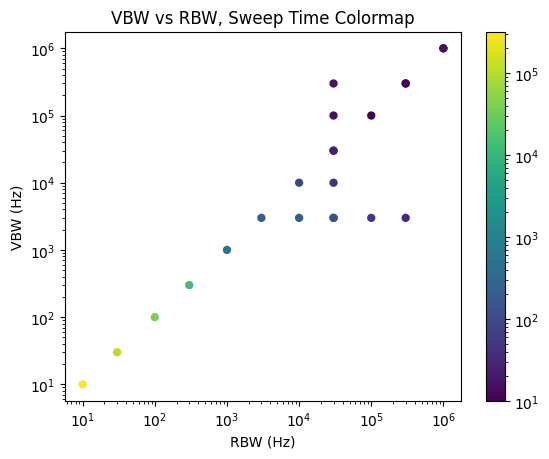

In [23]:
rbw_1b = [10e3,10,30,100,300,1e3,3e3,30e3,100e3,300e3,1e6,30e3,30e3,30e3,30e3,10e3,30e3,100e3,300e3,1e6,300e3,30e3] # db
vbw_1b = [10e3,10,30,100,300,1e3,3e3,30e3,100e3,300e3,1e6,100e3,300e3,10e3,3e3,3e3,3e3,3e3,3e3,1e6,300e3,30e3] # db
sweep_time_1b = [85.12, 321600,110900,36130,14000,550,215.4,16.03,10,10,10,16.03,16.03,42.76,141.6,227.1,141.6,53.11,31.87, 14.43,10,26.03]

data = np.zeros([10000, 10000])
# for i in range(len(rbw_1b)):
#     print(np.log10(rbw_1b))

# Create the colorplot
plt.xscale("log")
plt.yscale("log")
plt.scatter(rbw_1b, vbw_1b, c=sweep_time_1b, norm="log", edgecolors="none")
plt.colorbar()
plt.xlabel("RBW (Hz)")
plt.ylabel("VBW (Hz)")
plt.title("VBW vs RBW, Sweep Time Colormap")
plt.show()

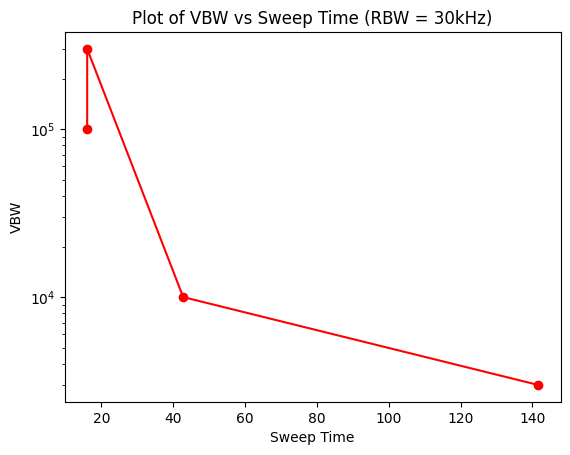

In [24]:
rbw_1b_1 = rbw_1b[15:19]
vbw_1b_1 = vbw_1b[11:15]

plt.plot(sweep_time_1b[11:15], vbw_1b_1, 'ro-')

plt.xlabel("Sweep Time")
plt.ylabel("VBW")
plt.title("Plot of VBW vs Sweep Time (RBW = 30kHz)")
plt.yscale("log")

linear_fit_vbw_sweeptime = np.polyfit(sweep_time_1b[11:15], np.log10(vbw_1b_1), 1)
slp_1b_VvT, in_1b_VvT = linear_fit_vbw_sweeptime
points = np.linspace(0, 300, 1000)
linFit = [in_1b_VvT + slp_1b_VvT*i for i in points]

Slope:  -0.013110472149667589 Intercept:  5.197902723017598


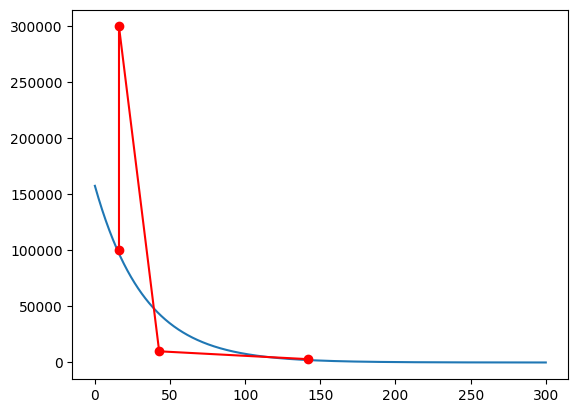

In [25]:
plt.plot(points, np.pow(10, linFit))
plt.plot(sweep_time_1b[11:15], vbw_1b_1, "ro-")


print("Slope: ", slp_1b_VvT, "Intercept: ", in_1b_VvT)

[227.1, 141.6, 53.11, 31.87]


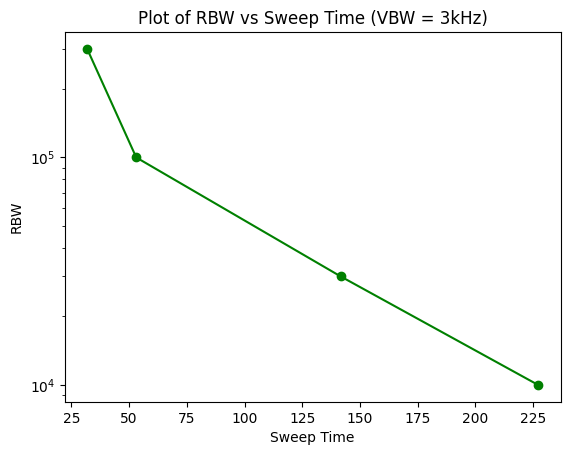

In [26]:
rbw_1b_2 = rbw_1b[15:19]

plt.plot(sweep_time_1b[15:19], rbw_1b_2, 'go-')
plt.xlabel("Sweep Time")
plt.ylabel("RBW")
plt.title("Plot of RBW vs Sweep Time (VBW = 3kHz)")
plt.yscale("log")

print(sweep_time_1b[15:19])

linear_fit_rbw_sweeptime = np.polyfit(sweep_time_1b[15:19], np.log10(rbw_1b_2), 1)
slp_1b_RvT, in_1b_RvT = linear_fit_rbw_sweeptime
points = np.linspace(0, 300, 1000)
linFit = [in_1b_RvT + slp_1b_RvT*i for i in points]

Slope:  -0.006970393092468513 Intercept:  5.529142611907611


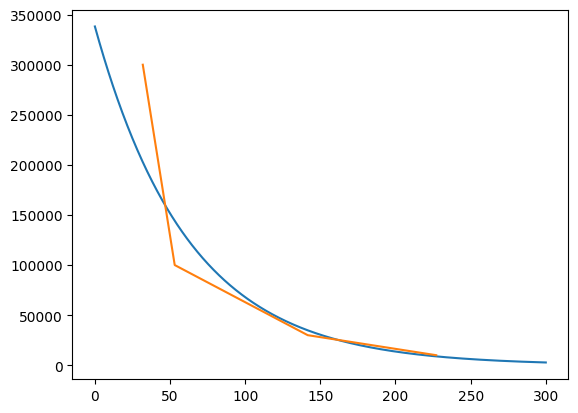

In [27]:
plt.plot(points, np.pow(10, linFit))
plt.plot(sweep_time_1b[15:19], rbw_1b_2)
print("Slope: ", slp_1b_RvT, "Intercept: ", in_1b_RvT)

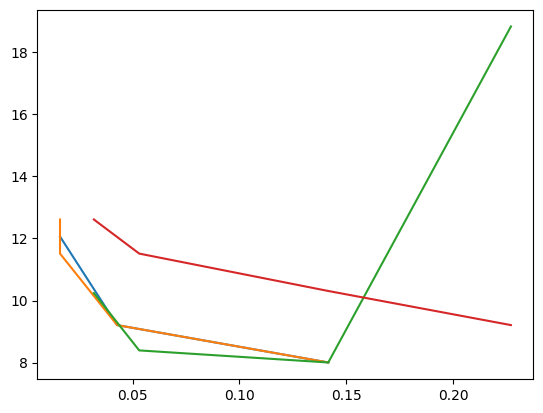

In [28]:
# st_r30k_log = [i for i in vbw_r30k]
st_v3k_log = [np.log(i) for i in rbw_v3k]

[slope2, slope, interc] = np.polyfit(sweep_time_r30k, np.log(vbw_r30k), 2)
polyfitted_r30k = [ interc + slope*i + slope2*i**2 for i in sweep_time_r30k]
polyfitted_v3k = [ interc + slope*i + slope2*i**2 for i in sweep_time_v3k]

plt.plot(sweep_time_r30k, polyfitted_r30k)
plt.plot(sweep_time_r30k, np.log(vbw_r30k))
plt.plot(sweep_time_v3k, polyfitted_v3k)
plt.plot(sweep_time_v3k, np.log(rbw_v3k))

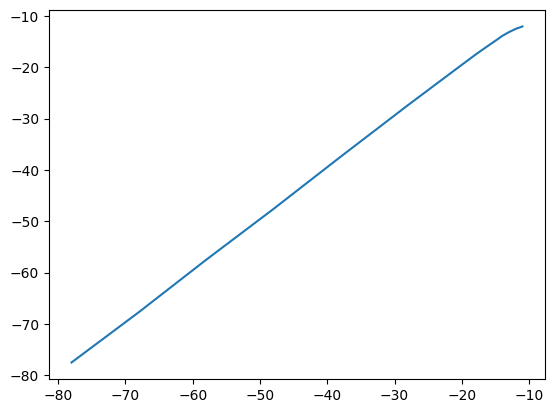

In [93]:
## with a 30 dB Attenuation

atten_3a = 30
in_pow_3a = [-78, -68, -58, -48,-38,-28,-20,-18,-17,-16,-15,-14,-13,-12,-11]
out_pow_3a = [-77.5,-67.7,-57.5,-47.6,-37.4,-27.36,-19.5,-17.55,-16.62,-15.71,-14.81,-13.88,-13.14,-12.51,-12.04]

out_pow_noatten_3a = [i + atten_3a for i in out_pow_3a]

## Gain equation given by P_out - P_in + Attenuation

gain_3a = []
for i in range(len(in_pow_3a)):
    val = out_pow_3a[i] - in_pow_3a[i] + atten_3a
    gain_3a.append(val)
    # print(out_pow_3a[i])
    # print(val)
    # print(in_pow_3a[i], '\n')

plt.plot(in_pow_3a, out_pow_3a)

-1   -1.0662265753215467


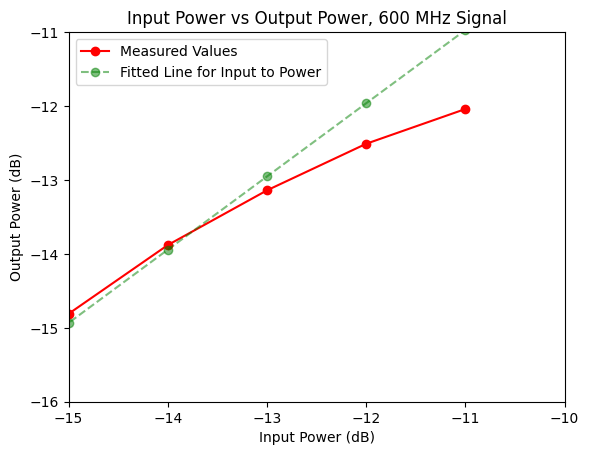

In [94]:
## 3a polyfit and finding what happens at P = -1 dB
plt.plot(in_pow_3a, out_pow_3a, 'ro-', label="Measured Values")

[slope_3a, interc_3a] = np.polyfit(in_pow_3a, out_pow_3a, 1)

in_pow_3a_polyfit = in_pow_3a
in_pow_3a_polyfit.append(-1)
polyfit_3a = [interc_3a + slope_3a*i for i in in_pow_3a_polyfit]
plt.plot(in_pow_3a_polyfit, polyfit_3a, 'go--', alpha=0.5, label="Fitted Line for Input to Power")

print(in_pow_3a_polyfit[-1], " ", polyfit_3a[-1])

plt.xlabel("Input Power (dB)") ## is it dB or dBm???
plt.ylabel("Output Power (dB)")
plt.title("Input Power vs Output Power, 600 MHz Signal")

plt.xlim([-15, -10])
plt.ylim([-16, -11])

plt.legend()

Text(0.5, 1.0, 'Graph of Likely Difference Between Planned slope and the Slope of the Curved Value')

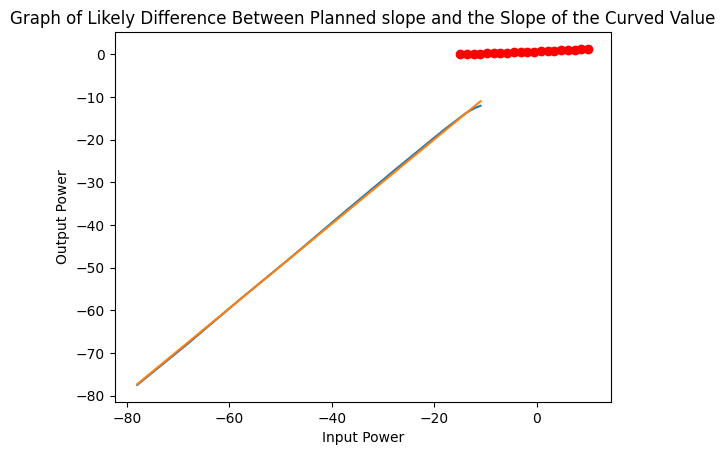

In [103]:

## with a 30 dB Attenuation

atten_3a = 30
in_pow_3a = [-78, -68, -58, -48,-38,-28,-20,-18,-17,-16,-15,-14,-13,-12,-11]
out_pow_3a = [-77.5,-67.7,-57.5,-47.6,-37.4,-27.36,-19.5,-17.55,-16.62,-15.71,-14.81,-13.88,-13.14,-12.51,-12.04]

out_pow_noatten_3a = [i + atten_3a for i in out_pow_3a]

## Gain equation given by P_out - P_in + Attenuation

gain_3a = []
for i in range(len(in_pow_3a)):
    val = out_pow_3a[i] - in_pow_3a[i] + atten_3a
    gain_3a.append(val)
    # print(out_pow_3a[i])
    # print(val)
    # print(in_pow_3a[i], '\n')

# plt.plot(in_pow_3a, out_pow_3a)




## 3a polyfit and finding what happens at P = -1 dB

[slope_3a, interc_3a] = np.polyfit(in_pow_3a, out_pow_3a, 1)
polyfit_3a_x2 = [interc_3a + slope_3a*i for i in in_pow_3a]

diff = [polyfit_3a_x2[i] - out_pow_3a[i] for i in range(len(out_pow_3a))]
[quad_3a_x2, slope_3a_x2, interc_3a_x2] = np.polyfit(in_pow_3a, diff, 2)

points = np.linspace(-15, 10, 20)
matched_diff = [ quad_3a_x2*i**2 + slope_3a_x2*i + interc_3a_x2 for i in points]

plt.plot(in_pow_3a, out_pow_3a)
plt.plot(in_pow_3a, polyfit_3a_x2)
plt.plot(points, matched_diff, 'ro-')
plt.xlabel("Input Power")
plt.ylabel("Output Power")
plt.title("Graph of Likely Difference Between Planned slope and the Slope of the Curved Value")

-1.0   0.06053390606272718


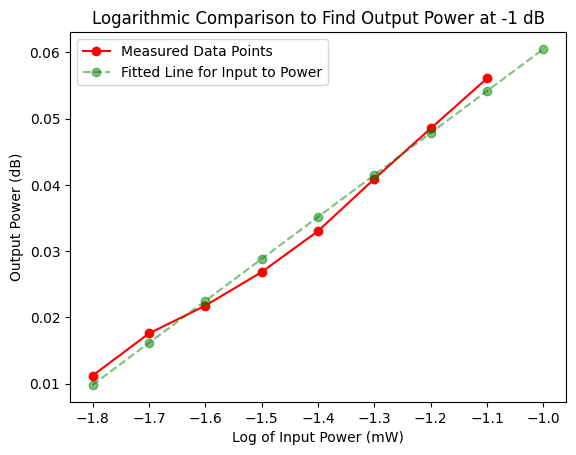

In [52]:
## 3a, looking only at the region around -15 to -11

in_pow_3a_curved  = in_pow_3a[-9:-1]
out_pow_3a_curved = out_pow_3a[-9:-1]


# converting from dB to mW so that I can do some fun log scale things
in_pow_3a_curved = [np.pow(10, i/10) for i in in_pow_3a_curved]
out_pow_3a_curved = [np.pow(10, i/10) for i in out_pow_3a_curved]

# continuing as usual


[slope_3a_curved, interc_3a_curved] = np.polyfit(np.log10(in_pow_3a_curved), out_pow_3a_curved, 1)

in_pow_3a_curved_polyfit = [i for i in in_pow_3a_curved]
in_pow_3a_curved_polyfit.append(0.1) # power -1 dB means that we have 10*(-1/10) which means log10(x/1mW), x = 0.1 mW

polyfit_3a_curved = [interc_3a_curved + slope_3a_curved*i for i in np.log10(in_pow_3a_curved_polyfit)]

plt.plot(np.log10(in_pow_3a_curved), out_pow_3a_curved, 'ro-', label="Measured Data Points")
plt.plot(np.log10(in_pow_3a_curved_polyfit), polyfit_3a_curved, 'go--', alpha=0.5, label="Fitted Line for Input to Power")
print(np.log10(in_pow_3a_curved_polyfit[-1]), ' ', polyfit_3a_curved[-1])

plt.xlabel("Log of Input Power (mW)")
plt.ylabel("Output Power (dB)")
plt.title("Logarithmic Comparison to Find Output Power at -1 dB")
plt.legend()

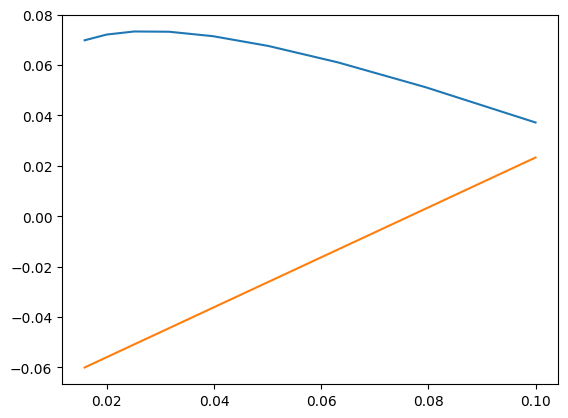

In [66]:
# plotting difference between linear and logarithmic slope

points_for_compare = np.linspace(-1, 6, 100)
lin_val = [interc_3a + slope_3a*i for i in points_for_compare]

diff_val = []

for i in range(len(polyfit_3a_curved)):
    diff_val.append(polyfit_3a_curved[i] - (interc_3a + slope_3a*in_pow_3a_curved_polyfit[i]))

plt.plot(in_pow_3a_curved_polyfit, diff_val)
plt.plot(in_pow_3a_curved_polyfit, [interc_3a + slope_3a*i for i in in_pow_3a_curved_polyfit])
# plt.plot(in_pow_3a_curved_polyfit[0:8], out_pow_3a[-9:-1])

In [ ]:
average_dif = 

In [ ]:
## 3b - Defining IIP1, IIP2, IIP3

## IIP1
atten_3b_iip1 = [30,30,30,30,30,30]
in_pow_3b_iip1 = [-58,-48,-38,-28,-20,-18]
out_pow_3b_iip1 = [-60.5,-50.5,-40.6,-30.5,-22.6,-20.8]
iip1_3b_no_atten = []
for i in range(len(out_pow_3b_iip1)):
    iip1_3b_no_atten.append(out_pow_3b_iip1[i] + atten_3b_iip1[i])
plt.plot(in_pow_3b_iip1, iip1_3b_no_atten)

## IIP2
atten_3b_iip2 = [30,30,30,30,30]
in_pow_3b_iip2 = [-18,-19,-20,-21,-23]
out_pow_3b_iip2_mid_peak = [-54.36,-56.65,-58.4,-61.11,-65.81]
iip2_3b_no_atten = []
for i in range(len(out_pow_3b_iip2_mid_peak)):
    iip2_3b_no_atten.append(out_pow_3b_iip2_mid_peak[i] + atten_3b_iip2[i])
plt.plot(in_pow_3b_iip2, iip2_3b_no_atten)

## IIP3
atten_3b_iip3 = [30, 30, 10, 10, 10, 0, 0]
in_pow_3b_iip3 = [-18, -19, -20, -22, -25, -30, -32]
out_pow_3b_iip3_2f1_1f2 = [-61.31, -65.89, -48.5, -54.6, -63.63, -66, -68.5]
out_pow_3b_iip3_1f1_2f2 = [-61.3, -65.37, -48.3, -54.5, -63.6, -66.2, -69.1]
out_pow_3b_iip3_avg = [(out_pow_3b_iip3_2f1_1f2[i]+out_pow_3b_iip3_1f1_2f2[i])/2 for i in range(len(out_pow_3b_iip3_2f1_1f2))]
iip3_3b_no_atten = []
for i in range(len(out_pow_3b_iip3_avg)):
    iip3_3b_no_atten.append(out_pow_3b_iip3_avg[i] + atten_3b_iip3[i])
plt.plot(in_pow_3b_iip3, iip3_3b_no_atten)

In [ ]:
## Getting Polyfits for the IIPx Values
[slp_3b_1, ic_3b_1] = np.polyfit(in_pow_3b_iip1, iip1_3b_no_atten,1)
[slp_3b_2, ic_3b_2] = np.polyfit(in_pow_3b_iip2, iip2_3b_no_atten,1)
[slp_3b_3, ic_3b_3] = np.polyfit(in_pow_3b_iip3, iip3_3b_no_atten,1)

points = np.linspace(-60, 35, 1000000)
polyfit_3b_iip1 = [ic_3b_1 + slp_3b_1*p for p in points]
polyfit_3b_iip2 = [ic_3b_2 + slp_3b_2*p for p in points]
polyfit_3b_iip3 = [ic_3b_3 + slp_3b_3*p for p in points]

plt.plot(points, polyfit_3b_iip1, alpha=0.5)
plt.plot(points, polyfit_3b_iip2, alpha=0.5)
plt.plot(points, polyfit_3b_iip3, alpha=0.5)
plt.plot(in_pow_3b_iip1, iip1_3b_no_atten)
plt.plot(in_pow_3b_iip2, iip2_3b_no_atten)
plt.plot(in_pow_3b_iip3, iip3_3b_no_atten)

x_val_3b = (iip1_3b_no_atten[0] - slp_3b_1*in_pow_3b_iip1[0] - (iip3_3b_no_atten[0] - slp_3b_3*in_pow_3b_iip3[0]))/(slp_3b_3-slp_3b_1)
y_val_3b = ic_3b_3 + slp_3b_3*x_val_3b

plt.scatter(x_val_3b, y_val_3b, c='red', label=f"IIP3 = ({x_val_3b:.2f}, {y_val_3b:.2f})")

x_val_3b_iip2 = (iip1_3b_no_atten[0] - slp_3b_1*in_pow_3b_iip1[0] - (iip2_3b_no_atten[0] - slp_3b_2*in_pow_3b_iip2[0]))/(slp_3b_2-slp_3b_1)
y_val_3b_iip2 = ic_3b_3 + slp_3b_3*x_val_3b_iip2
plt.scatter(x_val_3b_iip2, y_val_3b_iip2, c='blue', label=f"IIP2 =  = ({x_val_3b_iip2:.2f}, {y_val_3b_iip2:.2f})")

plt.xlabel("input power (dB)")
plt.ylabel("output power - no attenuation (dB)")
plt.title("Locating IIP3 and IIP2 on Graph")
plt.legend()

# print(x_val_3b, " ", y_val_3b)
# print(y_val_3b-30)
# print(x_val_3b_iip2, " ", y_val_3b_iip2)

In [ ]:
## 3d - Defining IIP1, IIP2, IIP3

## IIP1
atten_3d_iip1 = [30,30,30,30,30]
in_pow_3d_iip1 = [-50, -53, -55, -57, -58.2]
out_pow_3d_iip1 = [-16, -16.96, -18.08, -19.66, -20.74]
iip1_3d_no_atten = []
for i in range(len(out_pow_3d_iip1)):
    iip1_3d_no_atten.append(out_pow_3d_iip1[i] + atten_3d_iip1[i])
plt.plot(in_pow_3d_iip1, iip1_3d_no_atten, label="First Harmonic")

## IIP3
atten_3d_iip3 = [30,30,30,30,30]
in_pow_3d_iip3 = [-50, -53, -55, -57, -58.2]
out_pow_3d_iip3 = [-31.6, -38.2, -45.8, -53.6, -58.3]
iip3_3d_no_atten = []
for i in range(len(out_pow_3d_iip1)):
    iip3_3d_no_atten.append(out_pow_3d_iip3[i] + atten_3d_iip3[i])
plt.plot(in_pow_3d_iip3, iip3_3d_no_atten, label="Third Harmonic")

## Getting Polyfits for the IIPx Values
[slp_3d_1, ic_3d_1] = np.polyfit(in_pow_3d_iip1, iip1_3d_no_atten,1)
[slp_3d_3, ic_3d_3] = np.polyfit(in_pow_3d_iip3, iip3_3d_no_atten,1)

points = np.linspace(-60, -30, 100000)
polyfit_3d_iip1 = [ic_3d_1 + slp_3d_1*p for p in points]
polyfit_3d_iip3 = [ic_3d_3 + slp_3d_3*p for p in points]

plt.plot(points, polyfit_3d_iip1, alpha=0.5)
plt.plot(points, polyfit_3d_iip3, alpha=0.5)

x_val_3d = (iip1_3d_no_atten[0] - slp_3d_1*in_pow_3d_iip1[0] - (iip3_3d_no_atten[0] - slp_3d_3*in_pow_3d_iip3[0]))/(slp_3d_3-slp_3d_1)
y_val_3d = ic_3d_3 + slp_3d_3*x_val_3d
plt.scatter(x_val_3d, y_val_3d, c='red', label=f"IIP3 = ({x_val_3d:.2f}, {y_val_3d:.2f})")

plt.title("Cascaded Amplifier IIP3 Calculation, No Attenuation")
plt.xlabel("Input Power (dB)")
plt.ylabel("Output Power (dB)")
plt.legend()

In [ ]:
noise_value = power_real_wave / (bin_width/2 * np.ones(len(power_real_wave))) # noise value in dBm

noise_mW = [np.pow(10, n/10) for n in noise_value]
noisePower = np.sum(noise_mW)

# noiseVoltage = np.sqrt(noisePower**2 * 4 * Z_l)

# plt.plot(noise_value)
print(f"Total Voltage: {np.sum(noiseVoltage)} V")

In [ ]:
# https://www.ap.com/news/fft-scaling-for-noise
power_spectral_density = [p**2 / (bin_width * 2.73) for p in power_wave]  ## 1.73 comes from a table for Blackman Harris 3-term
amplitude_spectral_density = np.sqrt(power_spectral_density)

noise_density = np.sqrt([(np.sum(psd_i * bin_width)) for psd_i in power_spectral_density])
total_noise = np.sum(noise_density)
print(total_noise)